# Notebook Imports and Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Organizing the Dataset

In [2]:
img_size = (224, 224)  # standard size for CNNs
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values (0–255 → 0–1)
    rotation_range=20,        # random rotation up to 20 degrees
    width_shift_range=0.2,    # horizontal shifts
    height_shift_range=0.2,   # vertical shifts
    shear_range=0.2,          # geometric distortions
    zoom_range=0.2,           # random zoom
    horizontal_flip=True      # random horizontal flip
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4992 images belonging to 4 classes.
Found 1069 images belonging to 4 classes.


# Build the CNN Model

In [4]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)            

# Train the Model

In [5]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

Epoch 1/20
156/156 [==============================] - 254s 2s/step - loss: 0.7851 - acc: 0.6975 - val_loss: 0.5783 - val_acc: 0.7615
Epoch 2/20
156/156 [==============================] - 187s 1s/step - loss: 0.5492 - acc: 0.7839 - val_loss: 0.5345 - val_acc: 0.8026
Epoch 3/20
156/156 [==============================] - 188s 1s/step - loss: 0.5123 - acc: 0.8015 - val_loss: 0.5425 - val_acc: 0.7979
Epoch 4/20
156/156 [==============================] - 198s 1s/step - loss: 0.4699 - acc: 0.8229 - val_loss: 0.5525 - val_acc: 0.7605
Epoch 5/20
156/156 [==============================] - 202s 1s/step - loss: 0.4501 - acc: 0.8319 - val_loss: 0.4622 - val_acc: 0.8167
Epoch 6/20
156/156 [==============================] - 203s 1s/step - loss: 0.4467 - acc: 0.8255 - val_loss: 0.3768 - val_acc: 0.8344
Epoch 7/20
156/156 [==============================] - 201s 1s/step - loss: 0.4095 - acc: 0.8411 - val_loss: 0.3370 - val_acc: 0.8681
Epoch 8/20
156/156 [==============================] - 198s 1s/step - 

# Evaluate Performance

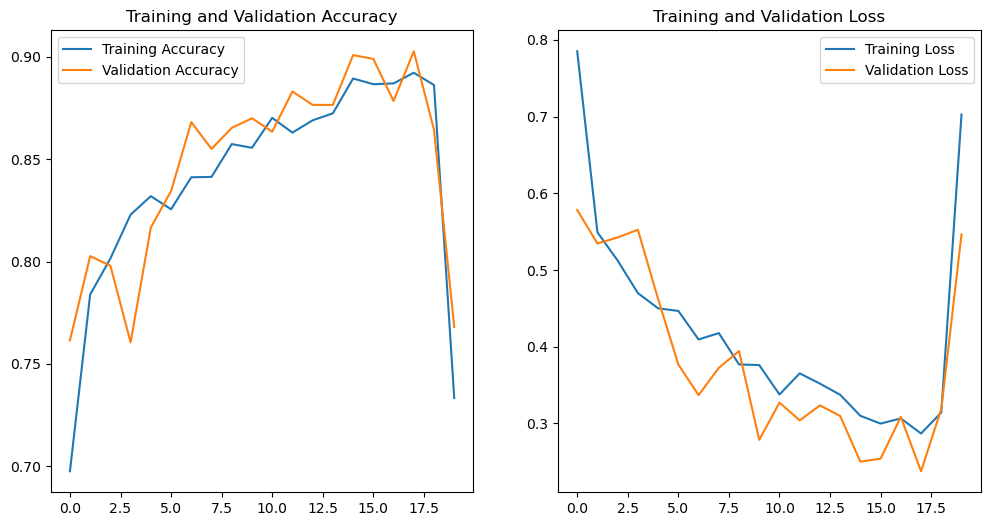

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the Model on the Test Set

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: keep order to match labels with predictions
)

Found 1071 images belonging to 4 classes.


In [11]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

34/34 [==============================] - 21s 624ms/step - loss: 0.6529 - acc: 0.7106
Test Accuracy: 0.7106
Test Loss: 0.6529


In [12]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)      # predicted class index
y_true = test_data.classes                      # true class index
class_labels = list(test_data.class_indices.keys())  # ['covid', 'normal', 'pneumonia', 'tuberculosis']

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

ModuleNotFoundError: No module named 'sklearn'

# Export Model

In [15]:
model.save("chest_xray_cnn_model.h5")